In [1]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ✅ Set repo root (folder that contains api/, data/, docs/, etc.)
REPO_ROOT = Path("/Users/lavanyasrinivas/Documents/AI-First-Preauth-Fraud-Detection/AI-First-Preauth-Fraud-Detection").resolve()
os.chdir(REPO_ROOT)

RAW_PATH = REPO_ROOT / "data/raw/creditcard.csv"
ENRICHED_PATH = REPO_ROOT / "data/processed/enriched.csv"
SCHEMA_PATH = REPO_ROOT / "docs/schema_enriched.json"

FIG_DIR = REPO_ROOT / "docs/figures/data/02_enrichment_simulation"
FIG_DIR.mkdir(parents=True, exist_ok=True)

print("CWD:", Path.cwd())
print("RAW_PATH exists:", RAW_PATH.exists(), RAW_PATH)
print("ENRICHED_PATH exists:", ENRICHED_PATH.exists(), ENRICHED_PATH)
print("SCHEMA exists:", SCHEMA_PATH.exists(), SCHEMA_PATH)
print("FIG_DIR:", FIG_DIR)


CWD: /Users/lavanyasrinivas/Documents/AI-First-Preauth-Fraud-Detection/AI-First-Preauth-Fraud-Detection
RAW_PATH exists: True /Users/lavanyasrinivas/Documents/AI-First-Preauth-Fraud-Detection/AI-First-Preauth-Fraud-Detection/data/raw/creditcard.csv
ENRICHED_PATH exists: True /Users/lavanyasrinivas/Documents/AI-First-Preauth-Fraud-Detection/AI-First-Preauth-Fraud-Detection/data/processed/enriched.csv
SCHEMA exists: True /Users/lavanyasrinivas/Documents/AI-First-Preauth-Fraud-Detection/AI-First-Preauth-Fraud-Detection/docs/schema_enriched.json
FIG_DIR: /Users/lavanyasrinivas/Documents/AI-First-Preauth-Fraud-Detection/AI-First-Preauth-Fraud-Detection/docs/figures/data/02_enrichment_simulation


In [2]:
if not RAW_PATH.exists():
    raise FileNotFoundError(f"Missing raw dataset: {RAW_PATH}")
if not ENRICHED_PATH.exists():
    raise FileNotFoundError(f"Missing enriched dataset: {ENRICHED_PATH}")

raw = pd.read_csv(RAW_PATH)
enr = pd.read_csv(ENRICHED_PATH)

print("RAW shape:", raw.shape)
print("ENRICHED shape:", enr.shape)

raw.head()


RAW shape: (284807, 31)
ENRICHED shape: (284807, 52)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
def label_stats(df, name="df"):
    if "Class" not in df.columns:
        print(f"{name}: No Class column")
        return
    vc = df["Class"].value_counts(dropna=False).to_dict()
    total = len(df)
    fraud = int(vc.get(1, 0))
    legit = int(vc.get(0, 0))
    print(f"{name}: total={total}, legit={legit}, fraud={fraud}, fraud_rate={fraud/total:.6f}")

def missingness(df, name="df"):
    miss = int(df.isna().sum().sum())
    print(f"{name}: total_missing_values={miss}")

label_stats(raw, "RAW")
label_stats(enr, "ENRICHED")
missingness(raw, "RAW")
missingness(enr, "ENRICHED")


RAW: total=284807, legit=284315, fraud=492, fraud_rate=0.001727
ENRICHED: total=284807, legit=284315, fraud=492, fraud_rate=0.001727
RAW: total_missing_values=0
ENRICHED: total_missing_values=0


##### What enrichment added (column diff)

In [4]:
raw_cols = set(raw.columns)
enr_cols = set(enr.columns)

added = sorted(list(enr_cols - raw_cols))
missing = sorted(list(raw_cols - enr_cols))
common = sorted(list(raw_cols & enr_cols))

print("Common columns:", len(common))
print("Added columns (enrichment):", len(added))
print(added)
print("Columns missing in enriched (should be none usually):", missing)


Common columns: 31
Added columns (enrichment): 21
['account_age_days', 'amount_zscore', 'avg_amount_7d', 'avg_spend_user_30d', 'billing_country', 'browser', 'country_mismatch', 'device_id', 'device_os', 'geo_distance_km', 'ip_country', 'ip_reputation', 'is_new_device', 'is_proxy_vpn', 'night_txn', 'shipping_country', 'token_age_days', 'txn_count_30m', 'txn_count_5m', 'txn_count_60m', 'weekend_txn']
Columns missing in enriched (should be none usually): []


##### Show example enriched fields (small preview)

In [5]:
enrichment_cols_to_preview = [
    "device_id","device_os","browser","is_new_device",
    "ip_country","is_proxy_vpn","ip_reputation",
    "txn_count_5m","txn_count_30m","txn_count_60m",
    "avg_amount_7d","account_age_days","token_age_days",
    "avg_spend_user_30d","billing_country","shipping_country",
    "geo_distance_km","country_mismatch","amount_zscore",
    "night_txn","weekend_txn"
]

existing = [c for c in enrichment_cols_to_preview if c in enr.columns]
enr[["Time","Amount","Class"] + existing].head(10)


,Time,Amount,Class,device_id,device_os,browser,is_new_device,ip_country,is_proxy_vpn,ip_reputation,...,account_age_days,token_age_days,avg_spend_user_30d,billing_country,shipping_country,geo_distance_km,country_mismatch,amount_zscore,night_txn,weekend_txn
0,0.0,149.62,0,dev_12345,Android,Firefox,False,SE,False,0.512,...,112,352,17.88,SE,FR,1882.9,True,1.0,True,True
1,0.0,2.69,0,dev_12345,MacOS,Chrome,False,IT,True,0.757,...,421,115,4.38,ES,CA,7059.7,True,-1.0,True,True
2,1.0,378.66,0,dev_1527590,Windows,Safari,False,FR,True,0.351,...,322,13,6.39,GB,PL,1529.7,True,1.0,True,True
3,1.0,123.50,0,dev_1527590,iOS,Chrome,False,NL,False,0.538,...,954,365,5.78,NL,IN,7110.4,True,-1.0,True,True
4,2.0,69.99,0,dev_1042835,iOS,Edge,False,SE,False,0.257,...,255,52,155.01,AU,US,15184.5,True,1.0,True,True
5,2.0,3.67,0,dev_1042835,MacOS,Firefox,False,BR,False,0.326,...,615,329,29.92,US,BR,7316.9,True,-1.0,True,True
6,4.0,4.99,0,dev_73325,Android,Chrome,True,SE,False,0.709,...,745,300,14.95,DE,IN,6752.2,True,0.0,True,True
7,7.0,40.80,0,dev_619060,Windows,Edge,False,ES,False,0.946,...,861,306,20.78,IN,AU,7813.5,True,-1.0,True,True
8,7.0,93.20,0,dev_619060,Android,Chrome,False,ES,False,0.366,...,459,81,77.95,FR,DE,815.8,True,1.0,True,True
9,9.0,3.68,0,dev_1649550,Android,Edge,False,PT,False,0.593,...,959,242,45.64,NL,AU,14793.0,True,0.0,True,True


##### Compare distributions: Amount (raw vs enriched)

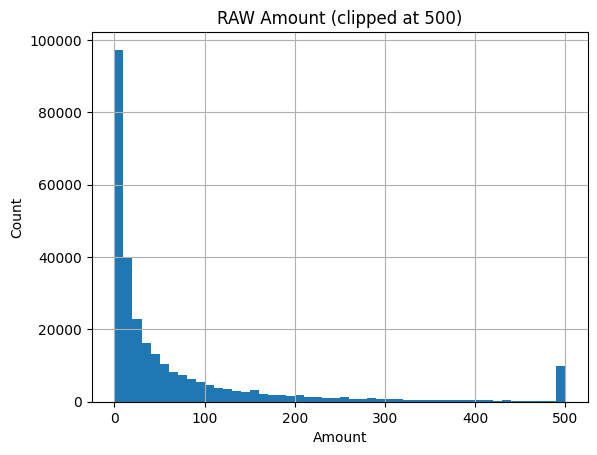

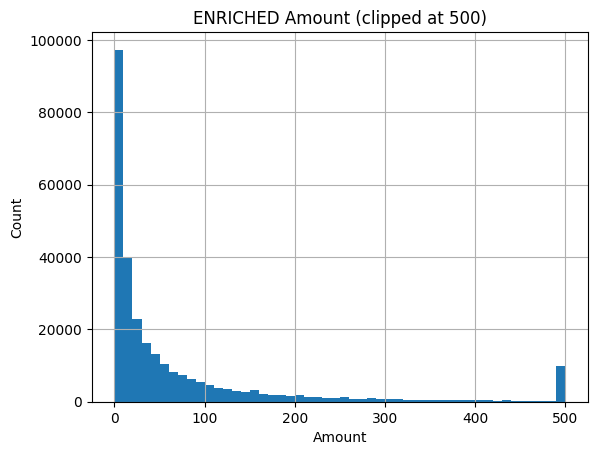

In [6]:
# Amount exists in both; should match exactly row-wise only if enrichment preserved order.
# We compare distribution-level (safe).
plt.figure()
raw["Amount"].clip(upper=500).hist(bins=50)
plt.title("RAW Amount (clipped at 500)")
plt.xlabel("Amount")
plt.ylabel("Count")
plt.savefig(FIG_DIR / "raw_amount_hist.png", dpi=200, bbox_inches="tight")
plt.show()

plt.figure()
enr["Amount"].clip(upper=500).hist(bins=50)
plt.title("ENRICHED Amount (clipped at 500)")
plt.xlabel("Amount")
plt.ylabel("Count")
plt.savefig(FIG_DIR / "enriched_amount_hist.png", dpi=200, bbox_inches="tight")
plt.show()


##### Fraud vs legit enrichment signal checks (simple but thesis-friendly)

In [7]:
# These should show differences by design (fraud skew higher VPN, newer device, etc.)
group = enr.groupby("Class", dropna=False)

summary = pd.DataFrame({
    "count": group.size(),
    "is_proxy_vpn_rate": group["is_proxy_vpn"].mean() if "is_proxy_vpn" in enr.columns else np.nan,
    "is_new_device_rate": group["is_new_device"].mean() if "is_new_device" in enr.columns else np.nan,
    "ip_reputation_mean": group["ip_reputation"].mean() if "ip_reputation" in enr.columns else np.nan,
    "geo_distance_km_mean": group["geo_distance_km"].mean() if "geo_distance_km" in enr.columns else np.nan,
    "txn_count_5m_mean": group["txn_count_5m"].mean() if "txn_count_5m" in enr.columns else np.nan,
})

summary


,count,is_proxy_vpn_rate,is_new_device_rate,ip_reputation_mean,geo_distance_km_mean,txn_count_5m_mean
Class,,,,,,
0,284315,0.069866,0.050033,0.499956,5576.452667,2.065164
1,492,0.378049,0.239837,0.811602,6598.109406,2.784553


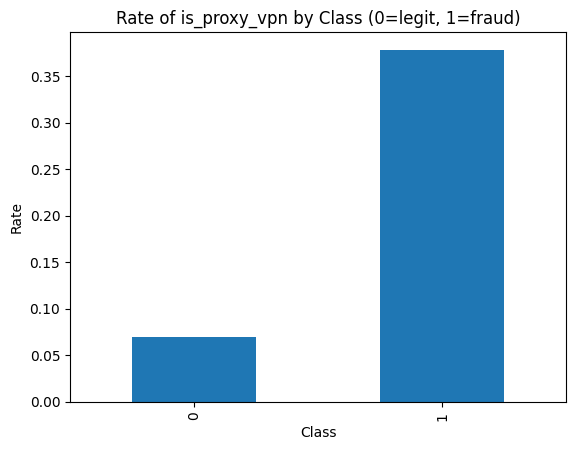

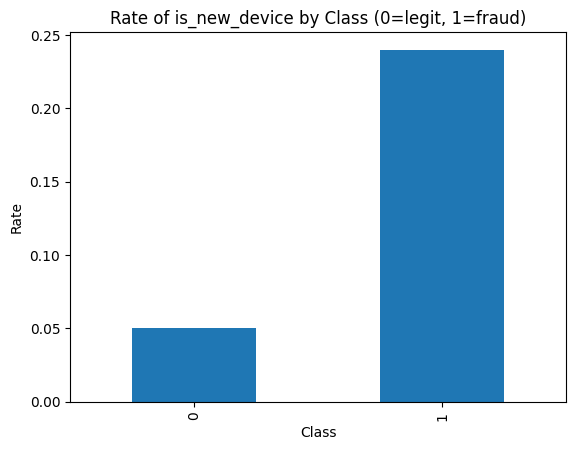

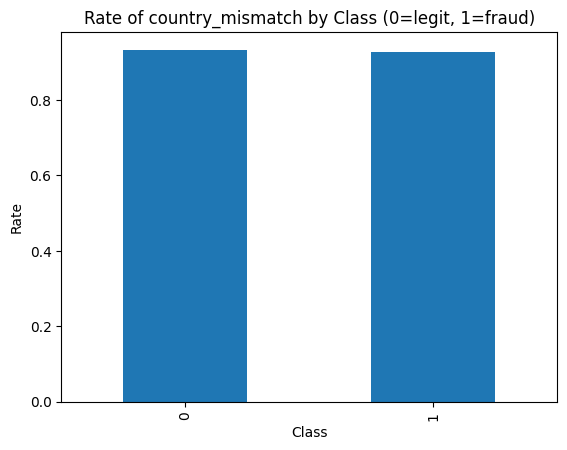

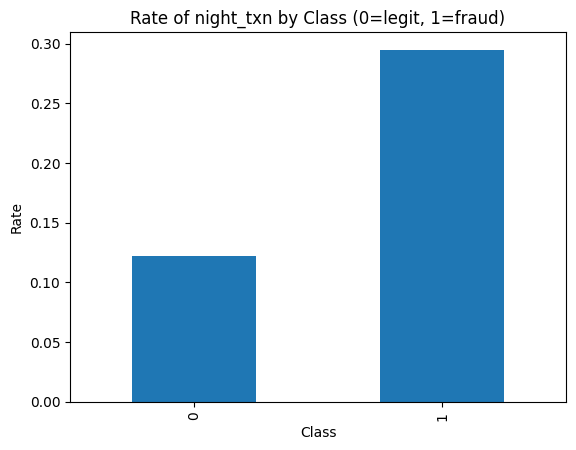

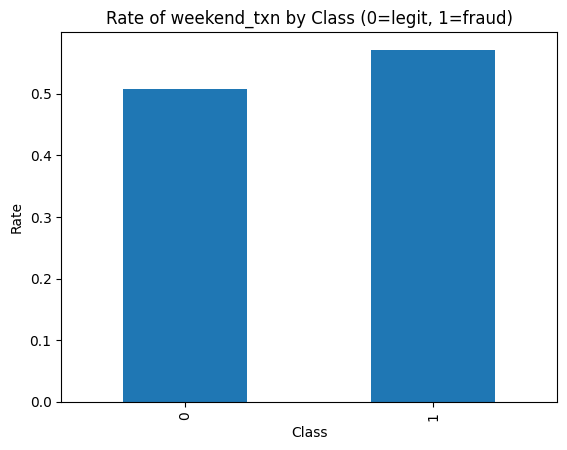

In [8]:
# Simple plots saved as thesis figures
cols = []
if "is_proxy_vpn" in enr.columns: cols.append("is_proxy_vpn")
if "is_new_device" in enr.columns: cols.append("is_new_device")
if "country_mismatch" in enr.columns: cols.append("country_mismatch")
if "night_txn" in enr.columns: cols.append("night_txn")
if "weekend_txn" in enr.columns: cols.append("weekend_txn")

for c in cols:
    rates = enr.groupby("Class")[c].mean()
    plt.figure()
    rates.plot(kind="bar")
    plt.title(f"Rate of {c} by Class (0=legit, 1=fraud)")
    plt.xlabel("Class")
    plt.ylabel("Rate")
    plt.savefig(FIG_DIR / f"rate_{c}_by_class.png", dpi=200, bbox_inches="tight")
    plt.show()


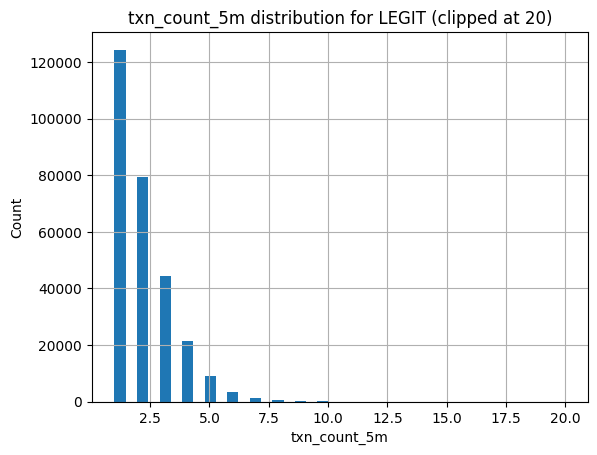

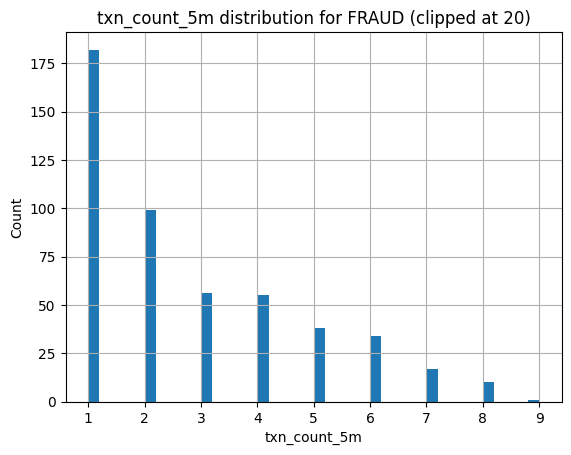

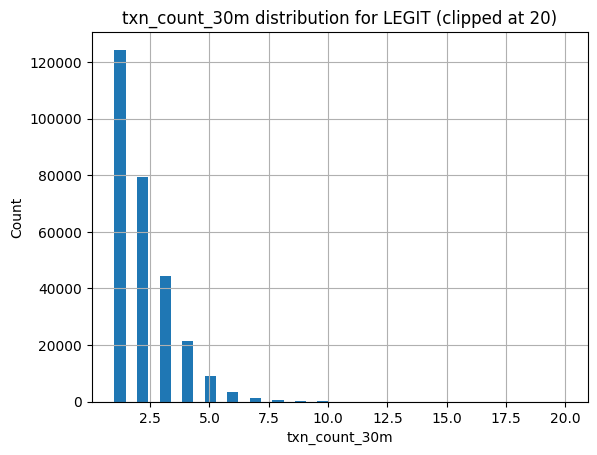

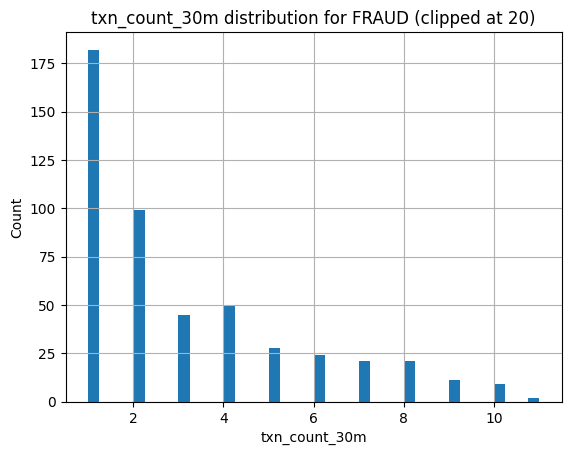

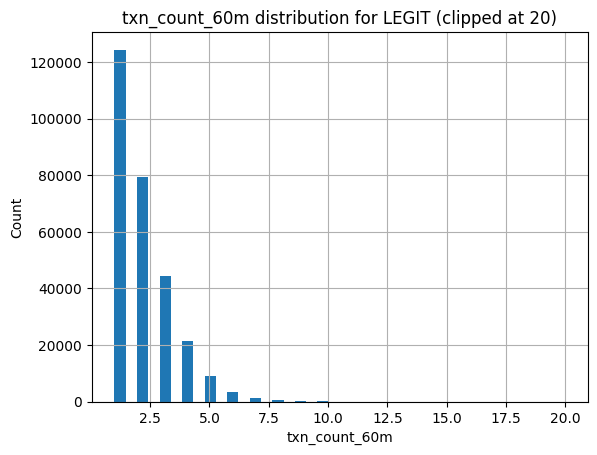

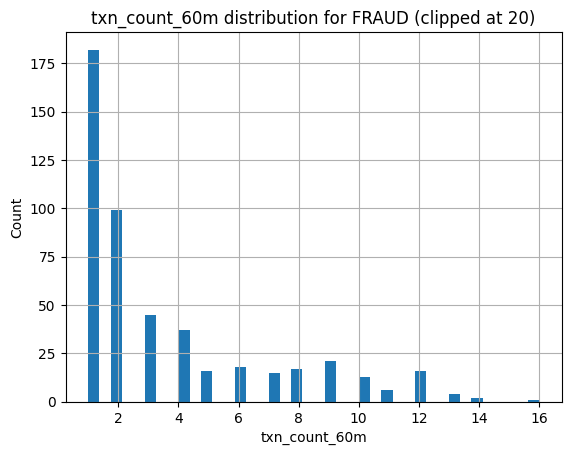

In [9]:
velocity_cols = [c for c in ["txn_count_5m","txn_count_30m","txn_count_60m"] if c in enr.columns]

for c in velocity_cols:
    plt.figure()
    enr.loc[enr["Class"]==0, c].clip(upper=20).hist(bins=40)
    plt.title(f"{c} distribution for LEGIT (clipped at 20)")
    plt.xlabel(c)
    plt.ylabel("Count")
    plt.savefig(FIG_DIR / f"{c}_legit_hist.png", dpi=200, bbox_inches="tight")
    plt.show()

    plt.figure()
    enr.loc[enr["Class"]==1, c].clip(upper=20).hist(bins=40)
    plt.title(f"{c} distribution for FRAUD (clipped at 20)")
    plt.xlabel(c)
    plt.ylabel("Count")
    plt.savefig(FIG_DIR / f"{c}_fraud_hist.png", dpi=200, bbox_inches="tight")
    plt.show()


In [10]:
added_cols = pd.Series(added, name="added_columns")
table = pd.DataFrame({
    "Added feature": added_cols,
    "Type (pandas)": [str(enr[c].dtype) for c in added_cols]
})
table.head(30)


,Added feature,Type (pandas)
0,account_age_days,int64
1,amount_zscore,float64
2,avg_amount_7d,float64
3,avg_spend_user_30d,float64
4,billing_country,object
5,browser,object
6,country_mismatch,bool
7,device_id,object
8,device_os,object
9,geo_distance_km,float64


In [11]:
summary_md = []
summary_md.append("# Enrichment Simulation Summary (02_enrichment_simulation)")
summary_md.append("")
summary_md.append(f"- Raw shape: {raw.shape[0]} rows × {raw.shape[1]} cols")
summary_md.append(f"- Enriched shape: {enr.shape[0]} rows × {enr.shape[1]} cols")
summary_md.append(f"- Added columns: {len(added)}")
summary_md.append("")
summary_md.append("## Added enrichment fields (sample)")
summary_md.append(", ".join(added[:25]) + (" ..." if len(added) > 25 else ""))

md_path = FIG_DIR / "enrichment_simulation_notes.md"
md_path.write_text("\n".join(summary_md), encoding="utf-8")
print("Wrote:", md_path)


Wrote: /Users/lavanyasrinivas/Documents/AI-First-Preauth-Fraud-Detection/AI-First-Preauth-Fraud-Detection/docs/figures/data/02_enrichment_simulation/enrichment_simulation_notes.md
